# Luminosity alignment

The most direct way of alignment for the gantry system to the SiPM of interest
would be the make sure the SiPM shows a maximum readout when exposed to the
light source when varying the $(x, y)$ position of the gantry. While this
functionality is built into the control program, this notebook is useful for
visualizing what is being done to get the optimal alignment position, as well as
generate nice plots for presentation reasons. 

Let us first import the require libraries as well as load in the required files.


In [1]:
import sipmanalyze.formats as forms
import numpy as np
import awkward as ak
import sipmanalyze.plotting as plt
from scipy.optimize import curve_fit

std_cont = forms.standard.standard_container.from_root('data/halign.root')

For alignment, we will fit the SiPM response to the expected inverse-square
response when varying the gantry coordinates. Let us first define a function
that is compatible with the `scipy.optimize.curve_fit` input:

In [ ]:
def model(xydata, N, x0, y0, z, p):
  """Inverse square model used for fitting"""
  x, y = xydata
  D = (x - x0)**2 + (y - y0)**2 + z**2
  return (N * z / D**1.5) + p


Next, we can set up the awkward arrays into a format that is required for the
curve-fit call, as well as getting a set of reasonable estimates for the fitting
data.

In [ ]:
# Data required for fitting
x = ak.to_numpy(std_cont.data.gantry_x)
y = ak.to_numpy(std_cont.data.gantry_y)
z = std_cont.data.gantry_z[0]  # Getting just the first entry for z
xydata = np.vstack([x, y])  # Stacking required for the function format

lumi = ak.to_numpy(std_cont.data.lumival)
unc = ak.to_numpy(std_cont.data.uncval)

# Getting the estimates
x0 = np.mean(x)
y0 = np.mean(y)
N = np.max(lumi) * (z**2)
p = np.min(lumi)


Then we can call the fit function (using the simple `curve_fit` method provided
in `scipy.optimize`)


In [ ]:
fitval, fitcovar = curve_fit(model,
                             xydata,
                             lumi,
                             p0=(N, x0, y0, z, p),
                             sigma=unc,
                             maxfev=1000000)

fitN = fitval[0]
fit_x0, err_x0 = fitval[1], fitcovar[1][1]**0.5
fit_y0, err_y0 = fitval[2], fitcovar[2][2]**0.5
fitz = fitval[3]
fitp = fitval[4]


Next we can plot the results using matplotlib

<Axes: xlabel='Gantry x [mm]', ylabel='Gantry y [mm]'>

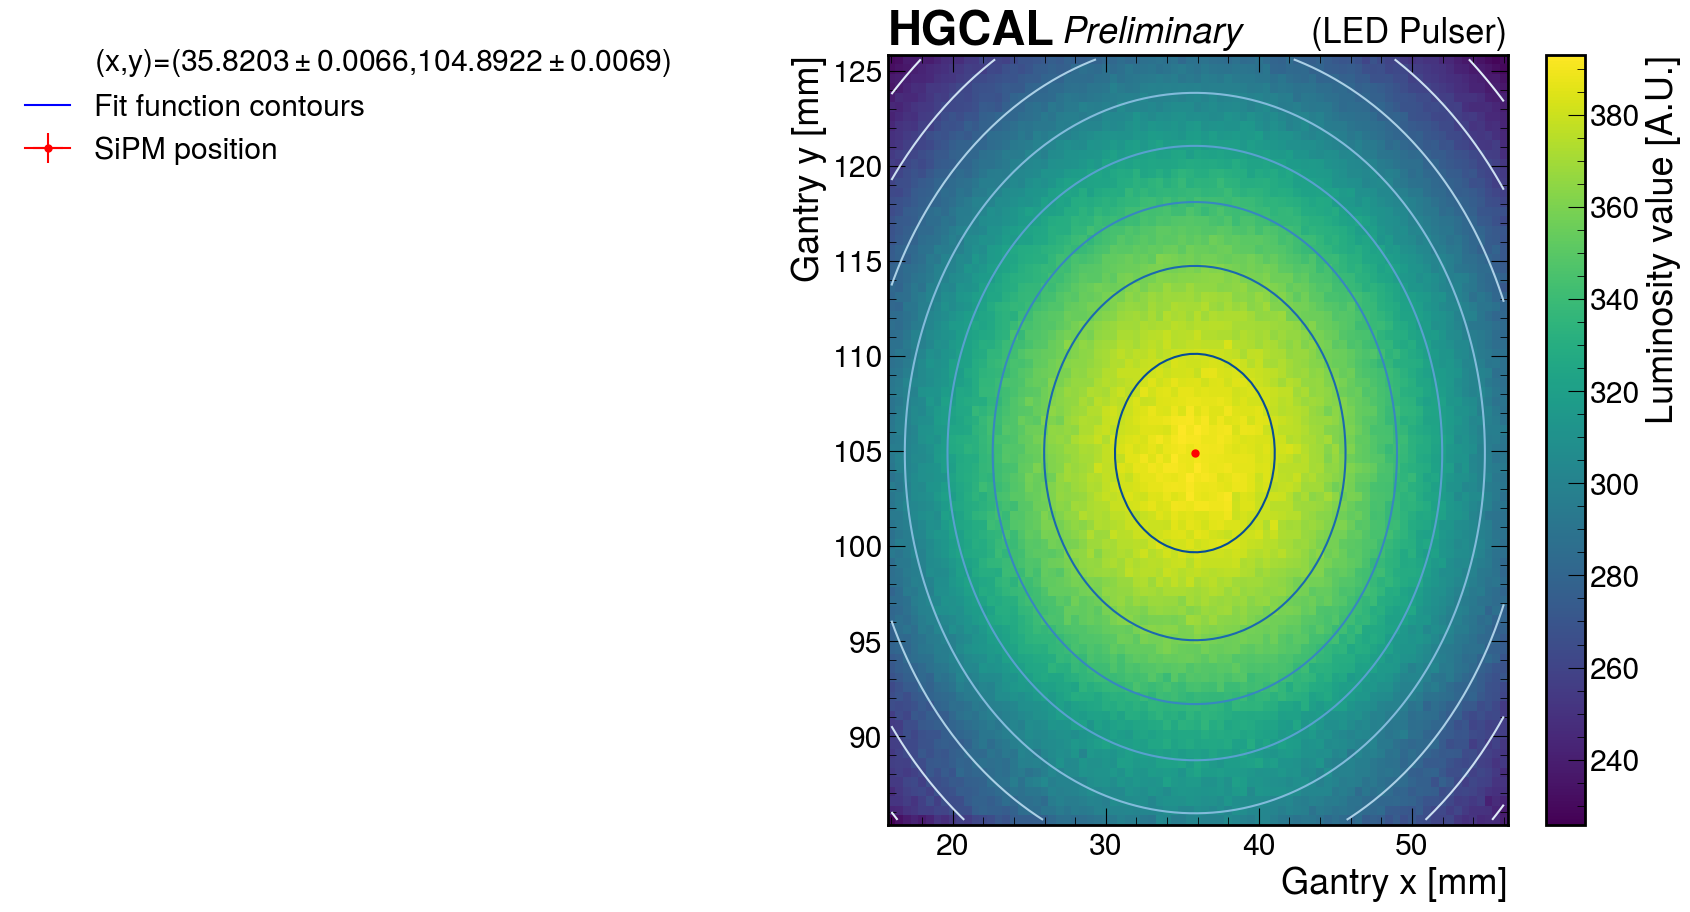

In [ ]:
fig, ax = plt.make_2d_figure()

# Plotting the response data
n_cells = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))
px = x.reshape(n_cells)
py = y.reshape(n_cells)
pl = lumi.reshape(n_cells)
pm = ax.pcolormesh(px, py, pl)
fig.colorbar(pm, ax=ax, label='Luminosity value [A.U.]')
ax.set_xlabel('Gantry x [mm]')
ax.set_ylabel('Gantry y [mm]')

x_str = plt.number_str(fit_x0, err_x0)
y_str = plt.number_str(fit_y0, err_y0)
# Plotting the center of the fitting results
ax.errorbar([fit_x0], [fit_y0],
            xerr=[err_x0],
            yerr=[err_y0],
            marker='o',
            markersize=5,
            color='r',
            label=f'SiPM position')
ax.plot([], [], color='none', label=f'(x,y)=({x_str},{y_str})')
# Plotting the fitting contours
ax.contour(px,
           py,
           model([px, py], fitN, fit_x0, fit_y0, fitz, fitp),
           cmap='Blues')
ax.plot([], [], color='blue', label='Fit function contours')
ax.legend(bbox_to_anchor=(-0.3, 1.05))
plt.add_std_2dlabel(ax=ax, label='Preliminary', rlabel='(LED Pulser)')
